# RUL prediction using Recurrent Neural Network
Trong đề tài này, chúng ta sẽ sử dụng LSTM để dự đoán RUL bộ dữ liệu động cơ cánh quạt phản lực FD001 của NASA và đi sâu vào lý thuyết của RNN.

In [47]:
# Nhập bộ dữ liệu CMAPSS
import numpy as np 
import pandas as pd

import os
for dirname, _, filenames in os.walk('C:/Users/phu20/OneDrive/Documents/lstm/CMaps'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:/Users/phu20/OneDrive/Documents/lstm/CMaps\Damage Propagation Modeling.pdf
C:/Users/phu20/OneDrive/Documents/lstm/CMaps\readme.txt
C:/Users/phu20/OneDrive/Documents/lstm/CMaps\RUL_FD001.txt
C:/Users/phu20/OneDrive/Documents/lstm/CMaps\RUL_FD002.txt
C:/Users/phu20/OneDrive/Documents/lstm/CMaps\RUL_FD003.txt
C:/Users/phu20/OneDrive/Documents/lstm/CMaps\RUL_FD004.txt
C:/Users/phu20/OneDrive/Documents/lstm/CMaps\test_FD001.txt
C:/Users/phu20/OneDrive/Documents/lstm/CMaps\test_FD002.txt
C:/Users/phu20/OneDrive/Documents/lstm/CMaps\test_FD003.txt
C:/Users/phu20/OneDrive/Documents/lstm/CMaps\test_FD004.txt
C:/Users/phu20/OneDrive/Documents/lstm/CMaps\train_FD001.txt
C:/Users/phu20/OneDrive/Documents/lstm/CMaps\train_FD002.txt
C:/Users/phu20/OneDrive/Documents/lstm/CMaps\train_FD003.txt
C:/Users/phu20/OneDrive/Documents/lstm/CMaps\train_FD004.txt
C:/Users/phu20/OneDrive/Documents/lstm/CMaps\x.txt
C:/Users/phu20/OneDrive/Documents/lstm/CMaps\.ipynb_checkpoints\prognostic_notebook-checkpoint.i

## 2. BỘ DỮ LIỆU CMAPSS
- Bộ dữ liệu CMAPSS bao gồm 4 tập dữ liệu chứa dữ liệu chuỗi thời gian đa biến và được chia thành các tập con huấn luyện(train data) và thử nghiệm(test data) và tập RUL(chu kì hoạt động trước khi hỏng) cho trước. Mỗi động cơ bắt đầu với mức độ mài mòn ban đầu khác nhau và sự thay đổi trong quá trình sử dụng mà người sử dụng không biết. 
- Động cơ đang hoạt động bình thường khi bắt đầu mỗi chuỗi thời gian, và phát sinh lỗi tại một số thời điểm trong chuỗi thời gian. Trong tập train, lỗi tăng dần cho đến khi lỗi hệ thống. Trong tập test, chuỗi thời gian kết thúc một thời gian trước khi hệ thống bị lỗi. Mục tiêu là dự đoán số chu kỳ hoạt động trước khi hỏng hóc của động cơ đó để so sánh với dữ liệu RUL cho trước đồng thời phân tích tập dữ liệu train và test.
- Dữ liệu được cung cấp dưới dạng tệp văn bản nén zip với 26 cột số, được phân tách bằng dấu cách. Mỗi hàng là một dữ liệu theo các biến được lấy trong một chu kỳ hoạt động, mỗi cột là một biến khác nhau. Các cột tương ứng với:
- 1) Số đơn vị
- 2) Thời gian(theo chu kỳ)
- 3) Chế độ cài đặt 1
- 4) Chế độ cài đặt 2
- 5) Chế độ cài đặt 3
- 5) Đo lường cảm biến 1
- 6) Đo lường cảm biến 2
- ...
- 26) Đo lường cảm biến 26
- Để cho dễ hiểu hơn, chúng ta sẽ tiến hành phân tích bộ dữ liệu:

## Phân tích tập dữ liệu train

In [48]:
#Nhập thư viện cần thiết
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

np.random.seed(34)

In [49]:
# Đọc tập dữ liệu train có sẵn
train_data = pd.read_csv("C:/Users/phu20/OneDrive/Documents/lstm/CMaps/train_FD001.txt", sep= "\s+", header = None)
train_data.shape

(20631, 26)

In [50]:
# Hiển thị ra màn hình dữ liệu 5 chu kỳ hoạt động đầu tiên của động cơ
train_data.head()

0   1       2       3      4       5       6        7        8      9   \
0   1   1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60  14.62   
1   1   2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14  14.62   
2   1   3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20  14.62   
3   1   4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87  14.62   
4   1   5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22  14.62   

      10      11       12       13   14     15      16       17       18  \
0  21.61  554.36  2388.06  9046.19  1.3  47.47  521.66  2388.02  8138.62   
1  21.61  553.75  2388.04  9044.07  1.3  47.49  522.28  2388.07  8131.49   
2  21.61  554.26  2388.08  9052.94  1.3  47.27  522.42  2388.03  8133.23   
3  21.61  554.45  2388.11  9049.48  1.3  47.13  522.86  2388.08  8133.83   
4  21.61  554.00  2388.06  9055.15  1.3  47.28  522.19  2388.04  8133.80   

       19    20   21    22     23     24       25  
0  8.4195  0.03  392  2388  100.0  39.06  23.4190  
1  8.4318  0.03  392  2388  100.0  39.00  23.4236  
2  8.4178  0.03  390  2388  100.0  38.95  23.3442  
3  8.3682  0.03  392  2388  100.0  38.88  23.3739  
4  8.4294  0.03  393  2388  100.0  38.90  23.4044

In [51]:
# Hiển thị số động cơ trong tập train
np.unique(train_data[0])

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

Kết quả cho ta thấy có 100 động cơ trong dữ liệu của FD001.

In [52]:
# Hiển thị số chu kì hoạt động trước khi hỏng của mỗi động cơ
num_cycles_to_failure = train_data.groupby(0)[1].count()
num_cycles_to_failure.values

array([192, 287, 179, 189, 269, 188, 259, 150, 201, 222, 240, 170, 163,
       180, 207, 209, 276, 195, 158, 234, 195, 202, 168, 147, 230, 199,
       156, 165, 163, 194, 234, 191, 200, 195, 181, 158, 170, 194, 128,
       188, 216, 196, 207, 192, 158, 256, 214, 231, 215, 198, 213, 213,
       195, 257, 193, 275, 137, 147, 231, 172, 185, 180, 174, 283, 153,
       202, 313, 199, 362, 137, 208, 213, 213, 166, 229, 210, 154, 231,
       199, 185, 240, 214, 293, 267, 188, 278, 178, 213, 217, 154, 135,
       341, 155, 258, 283, 336, 202, 156, 185, 200], dtype=int64)

Kết quả cho ta thấy động cơ 1 sẽ hỏng sau 192 chu kì, động cơ 2 sẽ hỏng sau 287 chu kì,...tương tự với các động cơ còn lại

## Phân tích tập dữ liệu test

In [53]:
test_data = pd.read_csv("C:/Users/phu20/OneDrive/Documents/lstm/CMaps/test_FD001.txt", sep = "\s+", header = None)
test_data.shape

(13096, 26)

In [54]:
# Hiển thị ra màn hình dữ liệu 5 chu kỳ hoạt động đầu tiên của động cơ
test_data.head()

0   1       2       3      4       5       6        7        8      9   \
0   1   1  0.0023  0.0003  100.0  518.67  643.02  1585.29  1398.21  14.62   
1   1   2 -0.0027 -0.0003  100.0  518.67  641.71  1588.45  1395.42  14.62   
2   1   3  0.0003  0.0001  100.0  518.67  642.46  1586.94  1401.34  14.62   
3   1   4  0.0042  0.0000  100.0  518.67  642.44  1584.12  1406.42  14.62   
4   1   5  0.0014  0.0000  100.0  518.67  642.51  1587.19  1401.92  14.62   

      10      11       12       13   14     15      16       17       18  \
0  21.61  553.90  2388.04  9050.17  1.3  47.20  521.72  2388.03  8125.55   
1  21.61  554.85  2388.01  9054.42  1.3  47.50  522.16  2388.06  8139.62   
2  21.61  554.11  2388.05  9056.96  1.3  47.50  521.97  2388.03  8130.10   
3  21.61  554.07  2388.03  9045.29  1.3  47.28  521.38  2388.05  8132.90   
4  21.61  554.16  2388.01  9044.55  1.3  47.31  522.15  2388.03  8129.54   

       19    20   21    22     23     24       25  
0  8.4052  0.03  392  2388  100.0  38.86  23.3735  
1  8.3803  0.03  393  2388  100.0  39.02  23.3916  
2  8.4441  0.03  393  2388  100.0  39.08  23.4166  
3  8.3917  0.03  391  2388  100.0  39.00  23.3737  
4  8.4031  0.03  390  2388  100.0  38.99  23.4130

In [55]:
# Hiển thị số động cơ trong tập test
np.unique(test_data[0])

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

Số động cơ ở tập train và test đều bằng 100.

In [56]:
# Hiển thị số chu kì hoạt động của mỗi động cơ
test_data.groupby(0)[1].count().values

array([ 31,  49, 126, 106,  98, 105, 160, 166,  55, 192,  83, 217, 195,
        46,  76, 113, 165, 133, 135, 184, 148,  39, 130, 186,  48,  76,
       140, 158, 171, 143, 196, 145,  50, 203, 198, 126, 121, 125,  37,
       133, 123, 156, 172,  54, 152, 146,  73,  78, 303,  74, 144, 189,
       164, 121, 113, 136, 160, 176,  94, 147, 159, 232, 155, 168,  71,
       147,  71, 187,  54, 152,  68, 131, 112, 137,  88, 205, 162,  72,
       101, 133, 213, 162,  73, 172,  34, 110,  56,  68, 177, 146, 234,
       150, 244, 133,  89,  97, 134, 121,  97, 198], dtype=int64)

Chúng ta có thể thấy động cơ thứ nhất có 31 chu kì và 49 chu kì cho động cơ,...vv

## Phân tích tập dữ liệu RUL cho trước

In [58]:
# Hiển thị RUL của mỗi động cơ
true_rul = pd.read_csv('C:/Users/phu20/OneDrive/Documents/lstm/CMaps/RUL_FD001.txt', sep = '\s+', header = None)
true_rul[0].values

array([112,  98,  69,  82,  91,  93,  91,  95, 111,  96,  97, 124,  95,
       107,  83,  84,  50,  28,  87,  16,  57, 111, 113,  20, 145, 119,
        66,  97,  90, 115,   8,  48, 106,   7,  11,  19,  21,  50, 142,
        28,  18,  10,  59, 109, 114,  47, 135,  92,  21,  79, 114,  29,
        26,  97, 137,  15, 103,  37, 114, 100,  21,  54,  72,  28, 128,
        14,  77,   8, 121,  94, 118,  50, 131, 126, 113,  10,  34, 107,
        63,  90,   8,   9, 137,  58, 118,  89, 116, 115, 136,  28,  38,
        20,  85,  55, 128, 137,  82,  59, 117,  20], dtype=int64)

Động cơ thứ nhất có giá trị RUL là 112 tức là nó sẽ hư hỏng sau 112 chu kì và tương tự với các động cơ sau.

## Dự Đoán RUL
Sau khi đã phân tích về bộ dữ liệu chúng ta sẽ tiến hành dự đoán RUL.

In [59]:
# Nhập các thư viện cần thiết
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import numpy as np
import pandas as pd
import sklearn
import os
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import random
np.random.seed(34)

In [60]:
# Cấu hình các hàng và cột cho dữ liệu train
columns=["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21"]

In [61]:
# Đọc lại tập dữ liệu train sau khi được cấu hình
train_data = pd.read_csv("C:/Users/phu20/OneDrive/Documents/lstm/CMaps/train_FD001.txt", sep= "\s+", header = None,names=columns )

In [62]:
# Theo dữ liệu phân tích ở trên, động cơ 1 sẽ hư hỏng sau 192 chu kỳ hoạt động(RUL = 192)
# Do đó ta sử dụng mô hình suy giảm tuyến tính, chu kì hoạt động thứ 1 thì RUL sẽ còn 191 và tiếp tục thứ 2 sẽ còn 190,...
def add_rul(g):
    g['RUL'] = max(g['cycle']) - g['cycle']
    return g

train = train_data.groupby('id').apply(add_rul)

In [63]:
# Hiển thị dữ liệu tệp train với RUL giảm dần theo chu kì
train.head()

id  cycle     op1     op2    op3  sensor1  sensor2  sensor3  sensor4  \
0   1      1 -0.0007 -0.0004  100.0   518.67   641.82  1589.70  1400.60   
1   1      2  0.0019 -0.0003  100.0   518.67   642.15  1591.82  1403.14   
2   1      3 -0.0043  0.0003  100.0   518.67   642.35  1587.99  1404.20   
3   1      4  0.0007  0.0000  100.0   518.67   642.35  1582.79  1401.87   
4   1      5 -0.0019 -0.0002  100.0   518.67   642.37  1582.85  1406.22   

   sensor5  sensor6  sensor7  sensor8  sensor9  sensor10  sensor11  sensor12  \
0    14.62    21.61   554.36  2388.06  9046.19       1.3     47.47    521.66   
1    14.62    21.61   553.75  2388.04  9044.07       1.3     47.49    522.28   
2    14.62    21.61   554.26  2388.08  9052.94       1.3     47.27    522.42   
3    14.62    21.61   554.45  2388.11  9049.48       1.3     47.13    522.86   
4    14.62    21.61   554.00  2388.06  9055.15       1.3     47.28    522.19   

   sensor13  sensor14  sensor15  sensor16  sensor17  sensor18  sensor19  \
0   2388.02   8138.62    8.4195      0.03       392      2388     100.0   
1   2388.07   8131.49    8.4318      0.03       392      2388     100.0   
2   2388.03   8133.23    8.4178      0.03       390      2388     100.0   
3   2388.08   8133.83    8.3682      0.03       392      2388     100.0   
4   2388.04   8133.80    8.4294      0.03       393      2388     100.0   

   sensor20  sensor21  RUL  
0     39.06   23.4190  191  
1     39.00   23.4236  190  
2     38.95   23.3442  189  
3     38.88   23.3739  188  
4     38.90   23.4044  187

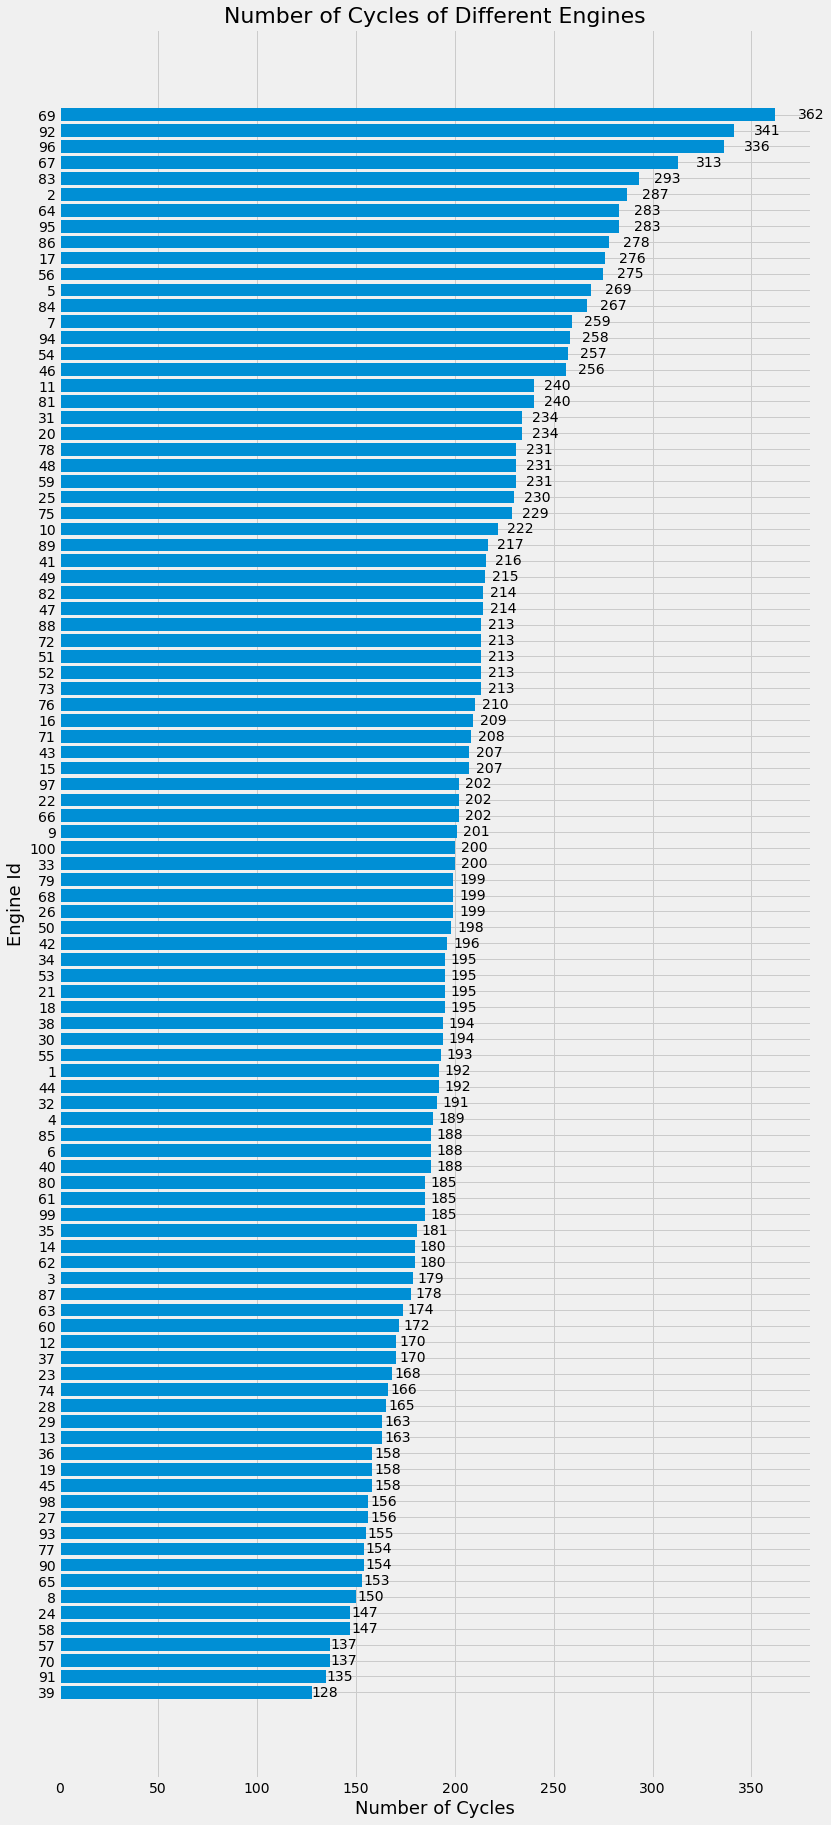

In [64]:
# Hiển thị RUL của các động cơ dưới dạng biểu đồ thang ngang
cnt_train=train_data[["id", "cycle"]].groupby("id").max().sort_values(by="cycle", ascending=True)
cnt_ind = [str(i) for i in cnt_train.index.to_list()]
cnt_val = list(cnt_train.cycle.values)

plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(12, 30))
rects = ax.barh(cnt_ind, cnt_val)
ax.set_title("Number of Cycles of Different Engines", fontsize=22)
ax.set_ylabel("Engine Id", fontsize=18)
ax.set_xlabel("Number of Cycles", fontsize=18)
ax.grid(True)

for rect in rects:
    width = rect.get_width()
    plt.text(1.05*rect.get_width(), rect.get_y()+0.5*rect.get_height(),
             '%d' % int(width),
             ha='center', va='center')

## 4. DỮ LIỆU CHUỖI THỜI GIAN ĐA BIẾN(TIME SERIES)
Các số thập phân ở mỗi cột và hàng của các tập dữ liệu là một dạng dữ liệu gọi là chuỗi thời gian đa biến, dữ liệu dạng này có đặc điểm là:
- Dữ liệu này có xu hướng(tăng giảm)
- Dữ liệu bị ảnh hưởng bởi thước đo thời gian. Trong trường hợp này dữ liệu có chu kỳ lặp đi lặp lại theo thước đo thời gian.
- Dự đoán dựa trên dữ liệu CMAPSS cho trước sẽ có sai số nên yêu cầu tính toán các dữ liệu phụ để tổng hợp và cho ra kết quả dự đoán chính xác nhất.

## Độ lệch chuẩn
- Độ lệch chuẩn của tập dữ liệu biểu hiện mức độ phân tán của tập dữ liệu khi được xử lí. Nó cho thấy sự chênh lệch về giá trị của từng thời điểm đánh giá so với giá trị trung bình.
- Công thức: 
$$ SD\ =\ \sqrt{\frac{\sum\left(x_i\ -\ \bar{x}\right)^2}{n-1}} $$ Trong đó :
 - $ x_i $ là giá trị của điểm i trong tập dữ liệu.
 - $ \bar{x} $ là giá trị của tập dữ liệu. 
 - n là tổng số biến quan sát trong dữ liệu

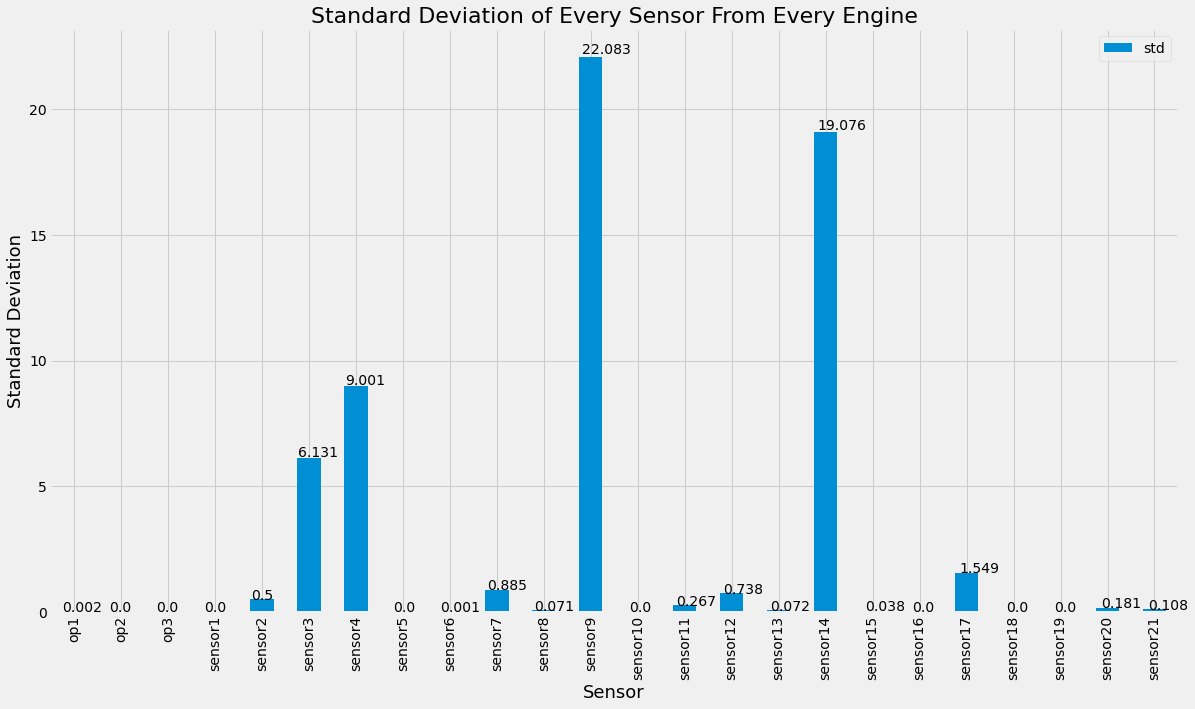

In [65]:
# Tính toán độ lệch chuẩn của mỗi cảm biến trong mỗi động cơ
subset_stats = train_data.agg(['mean', 'std']).T[2:]
ax = subset_stats.plot.bar(figsize=(18,10), 
                           y="std")
ax.set_title("Standard Deviation of Every Sensor From Every Engine", fontsize=22)
ax.set_xlabel("Sensor", fontsize=18)
ax.set_ylabel("Standard Deviation", fontsize=18)

for p in ax.patches:
    ax.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.005, p.get_height() * 1.005))

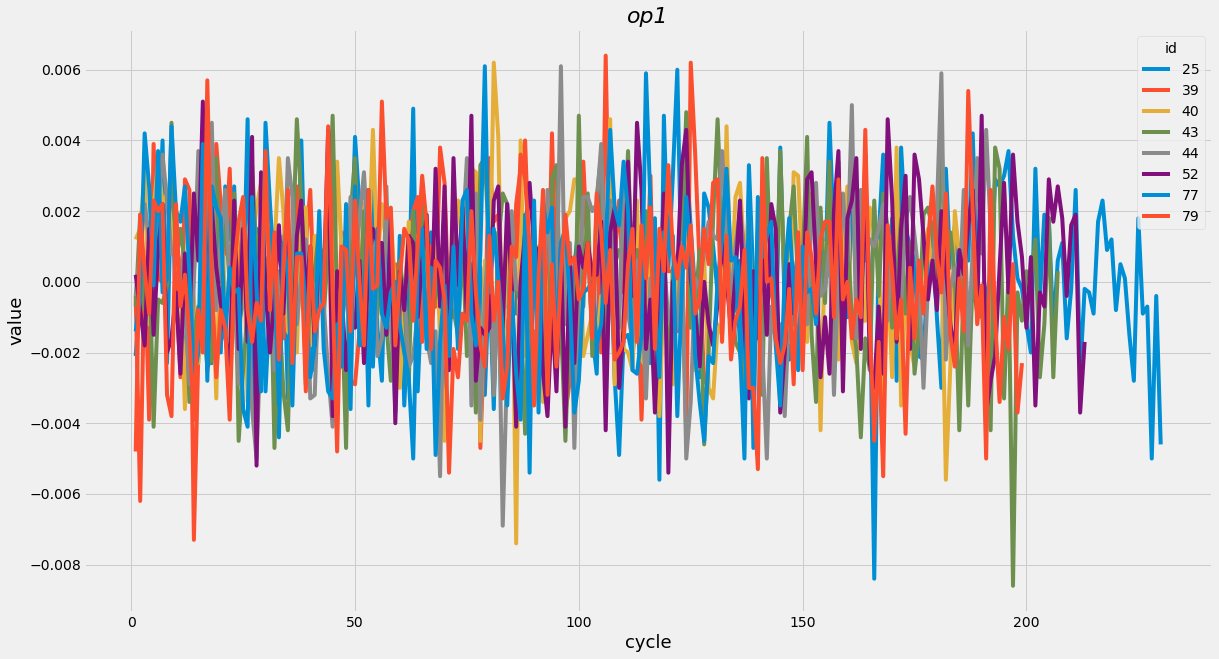

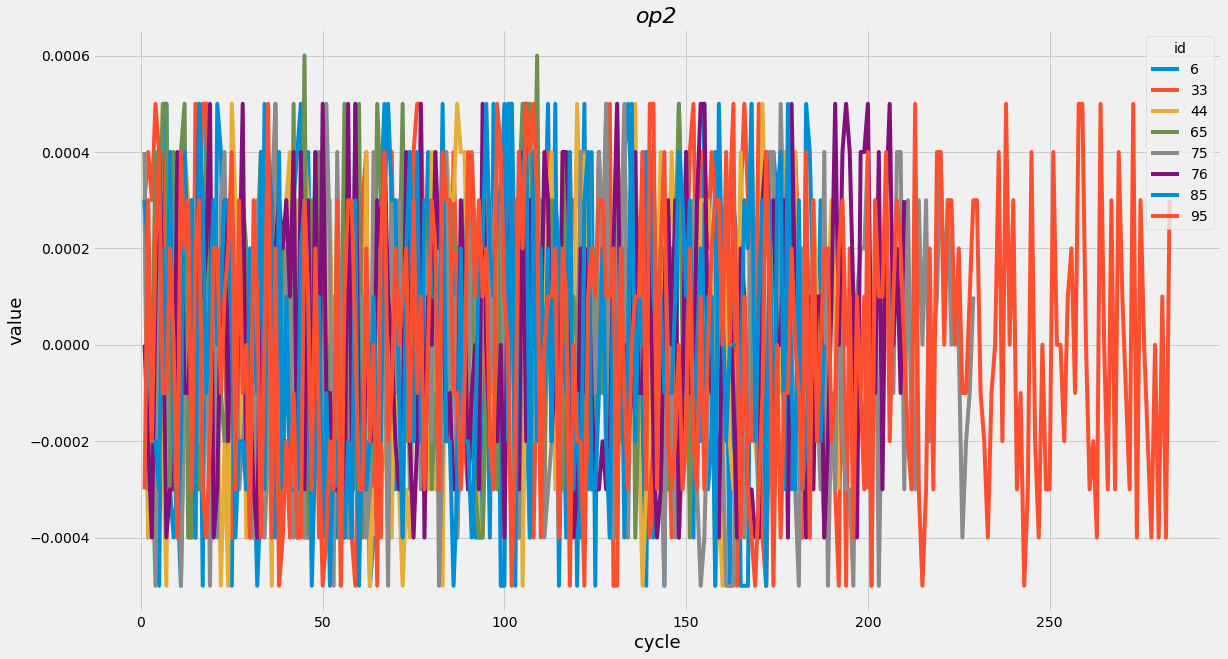

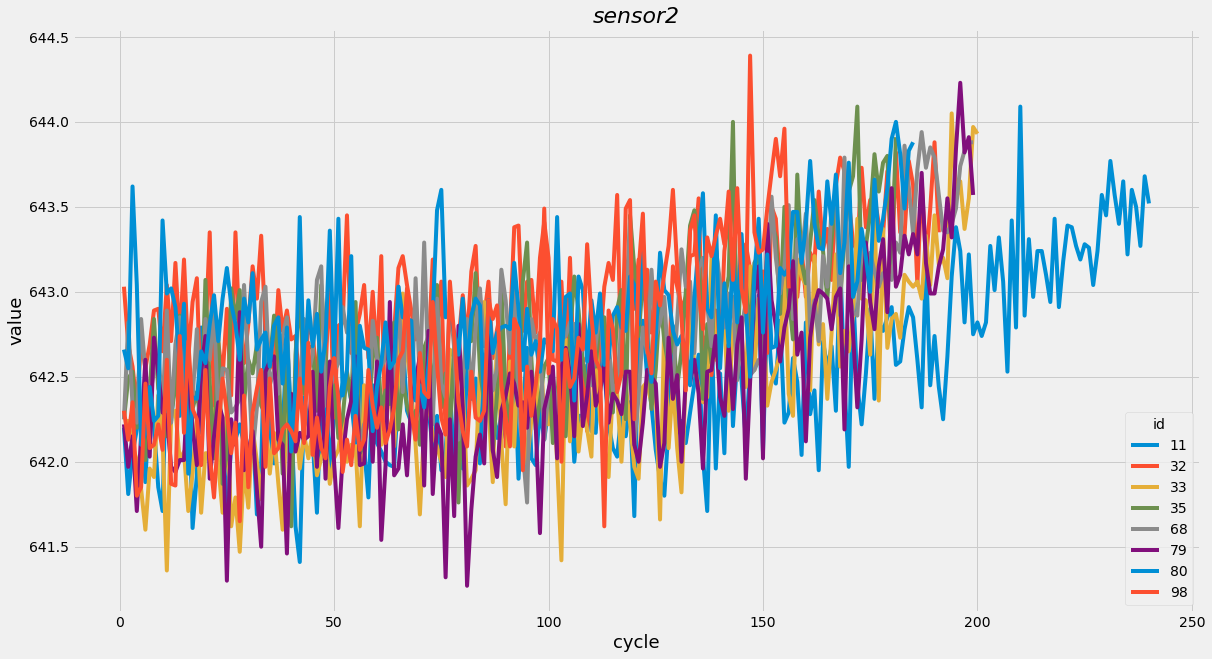

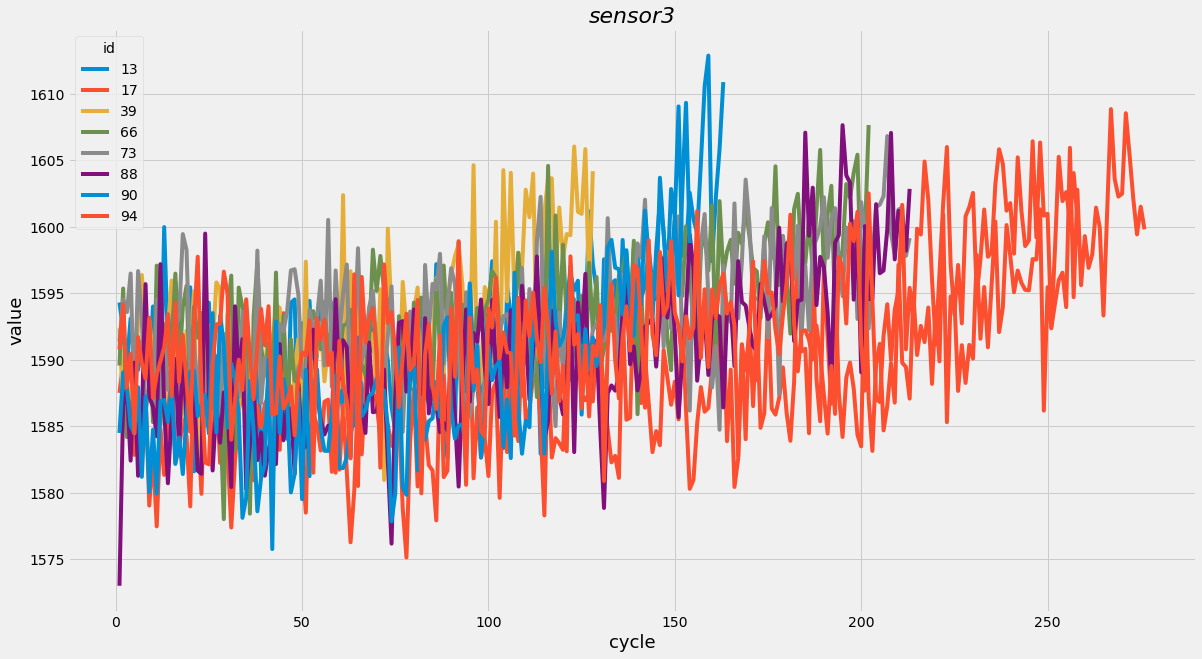

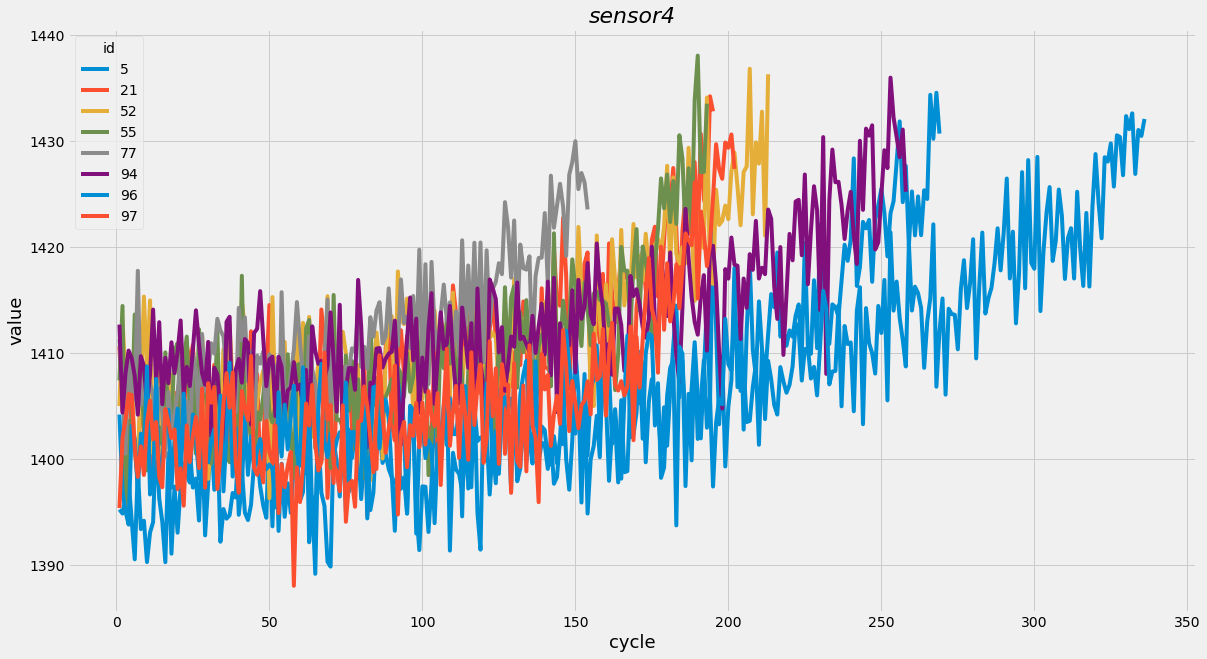

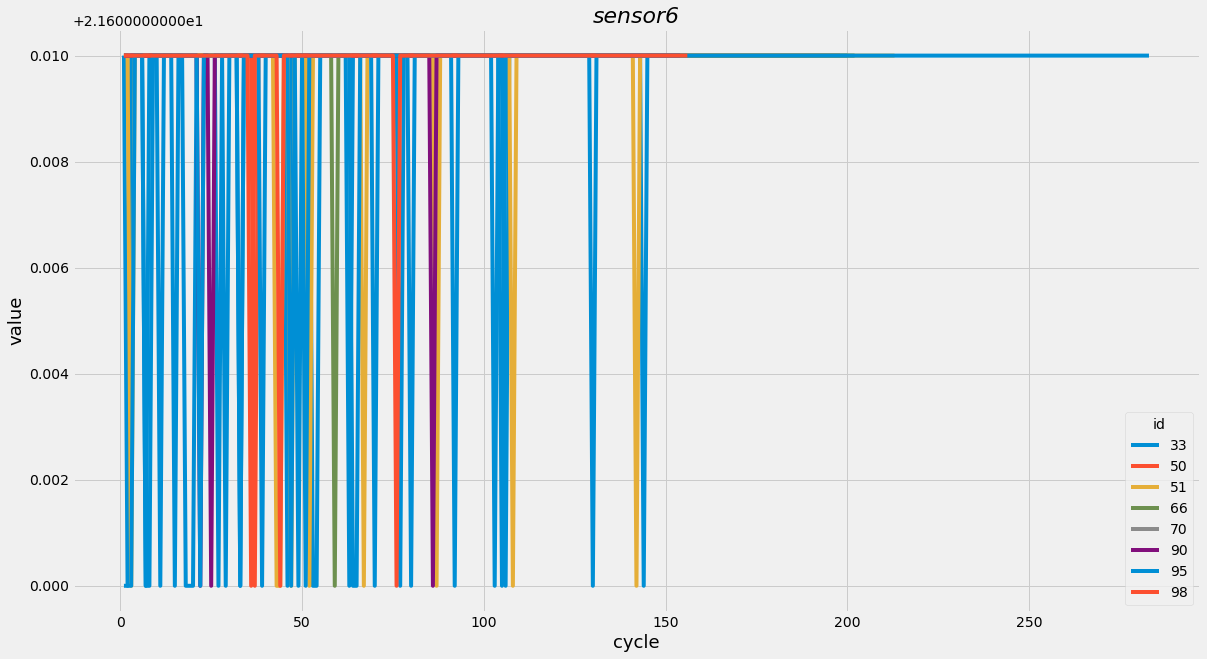

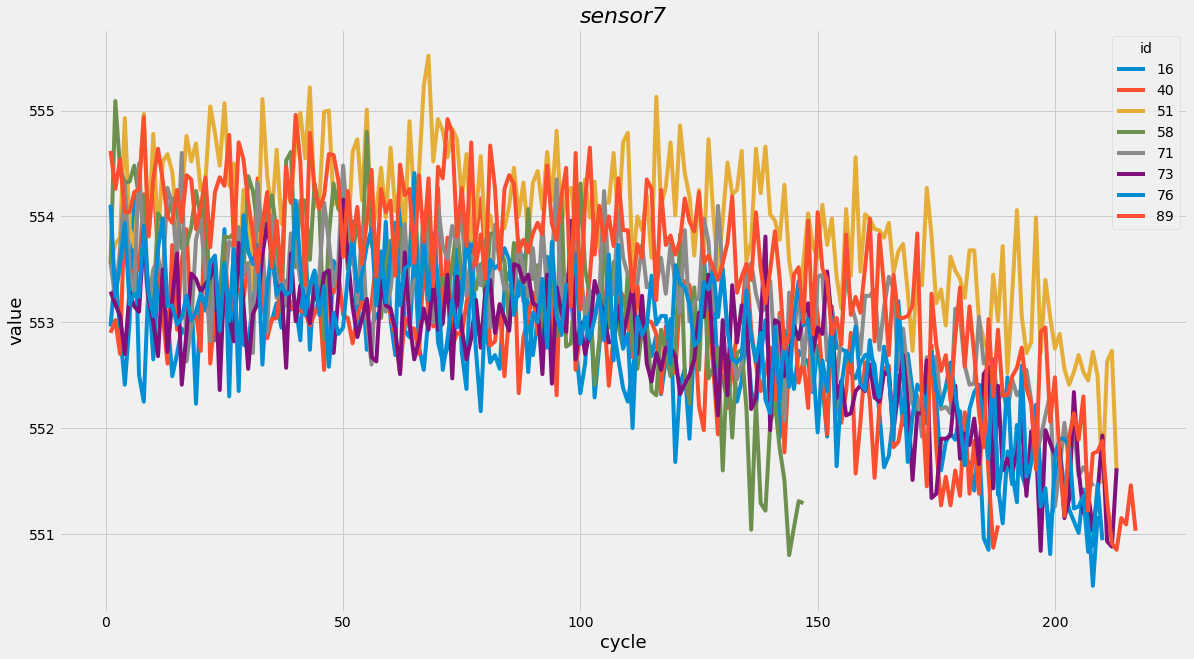

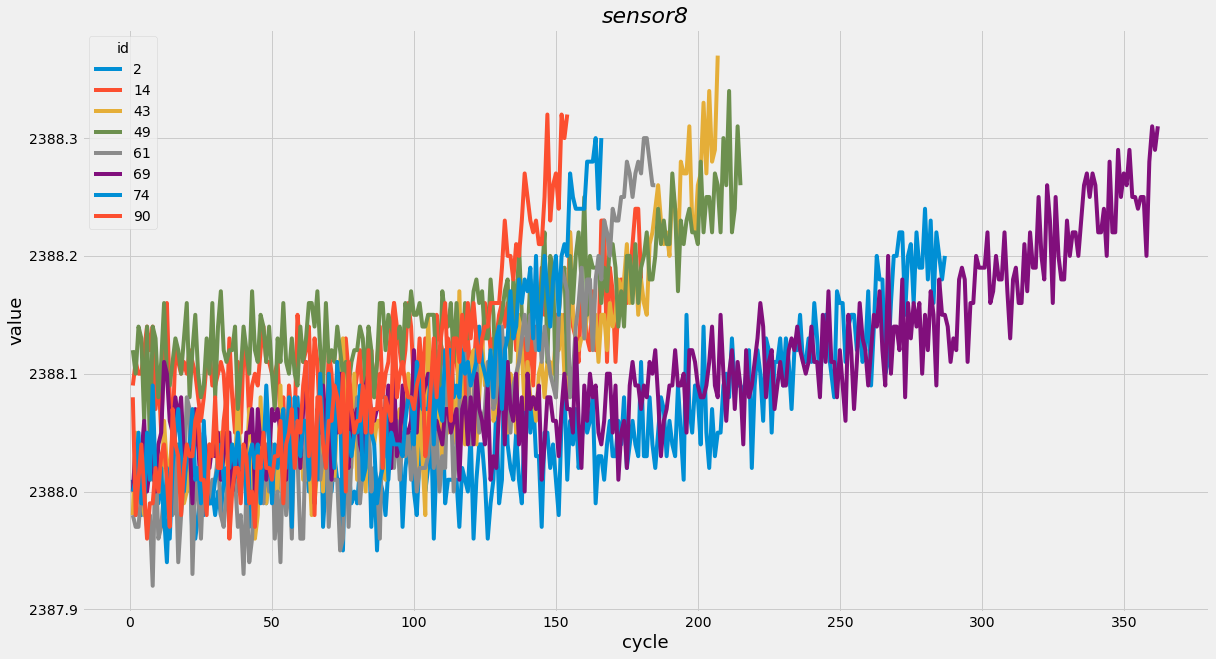

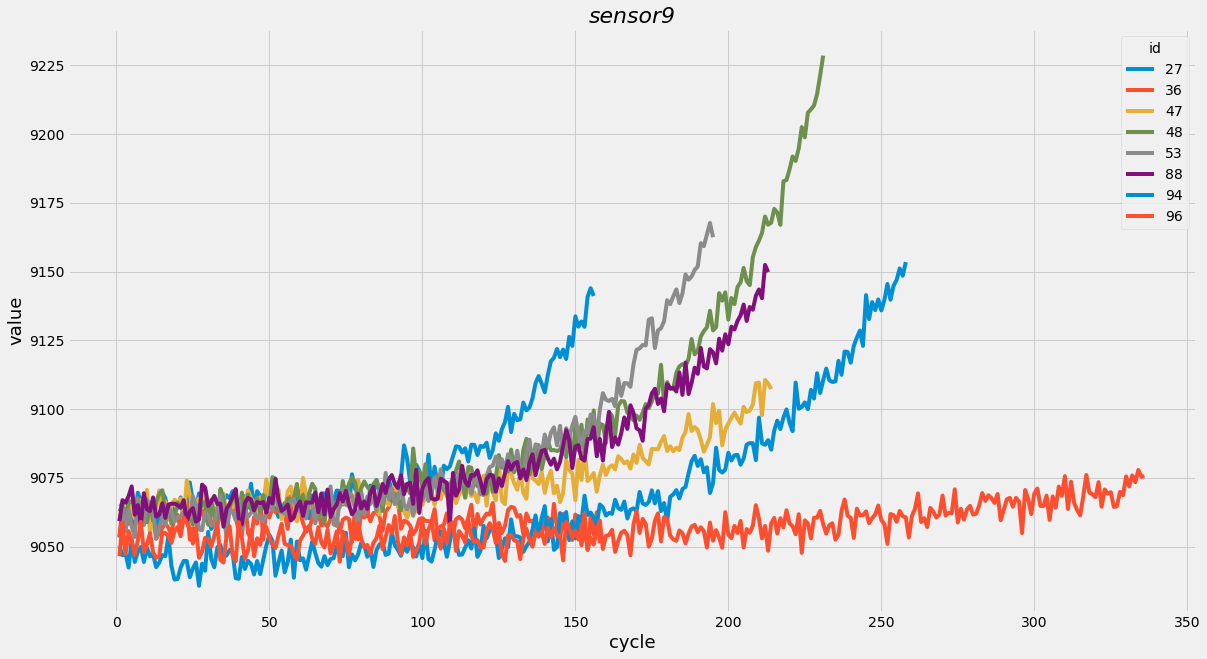

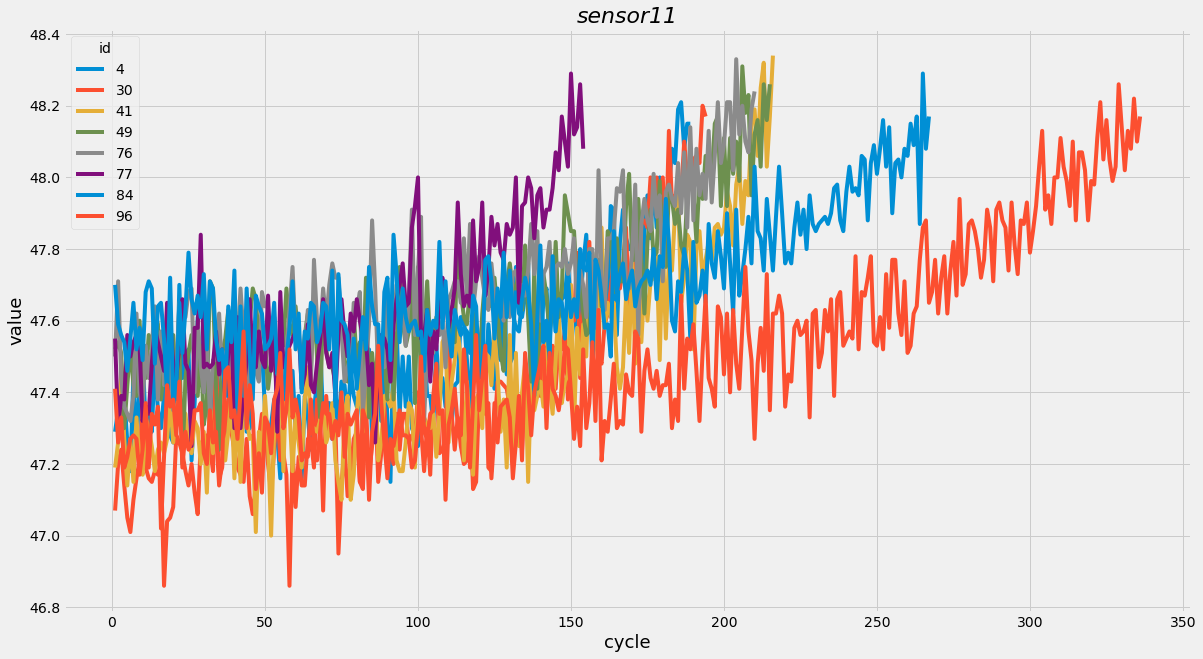

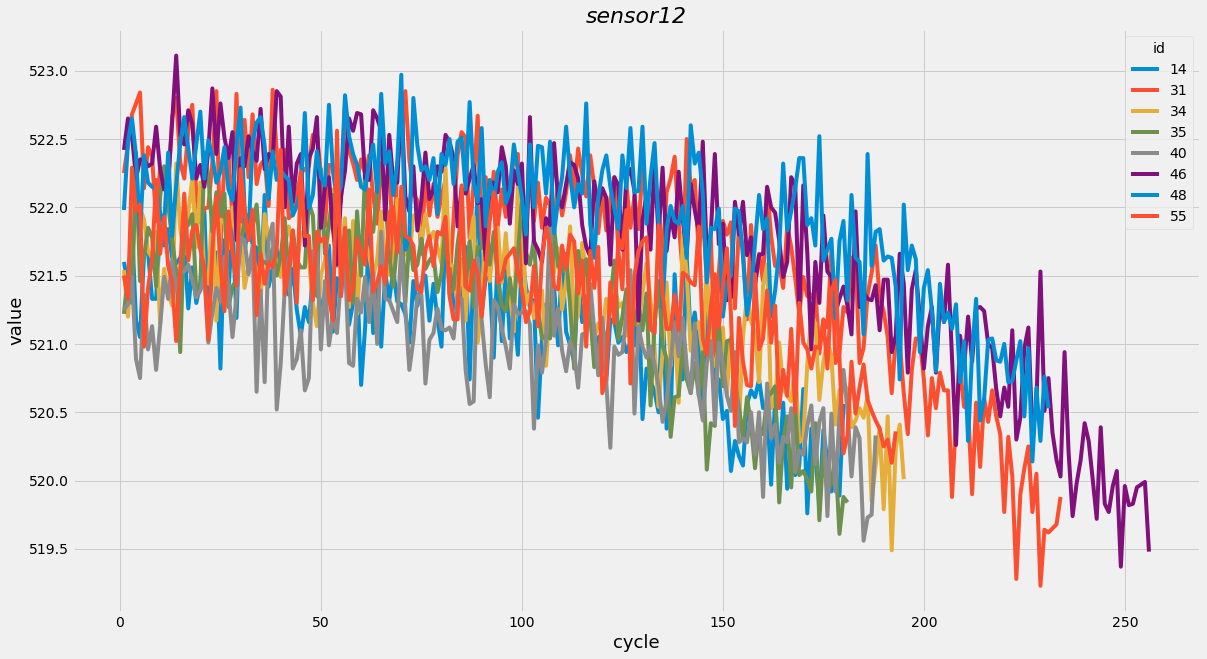

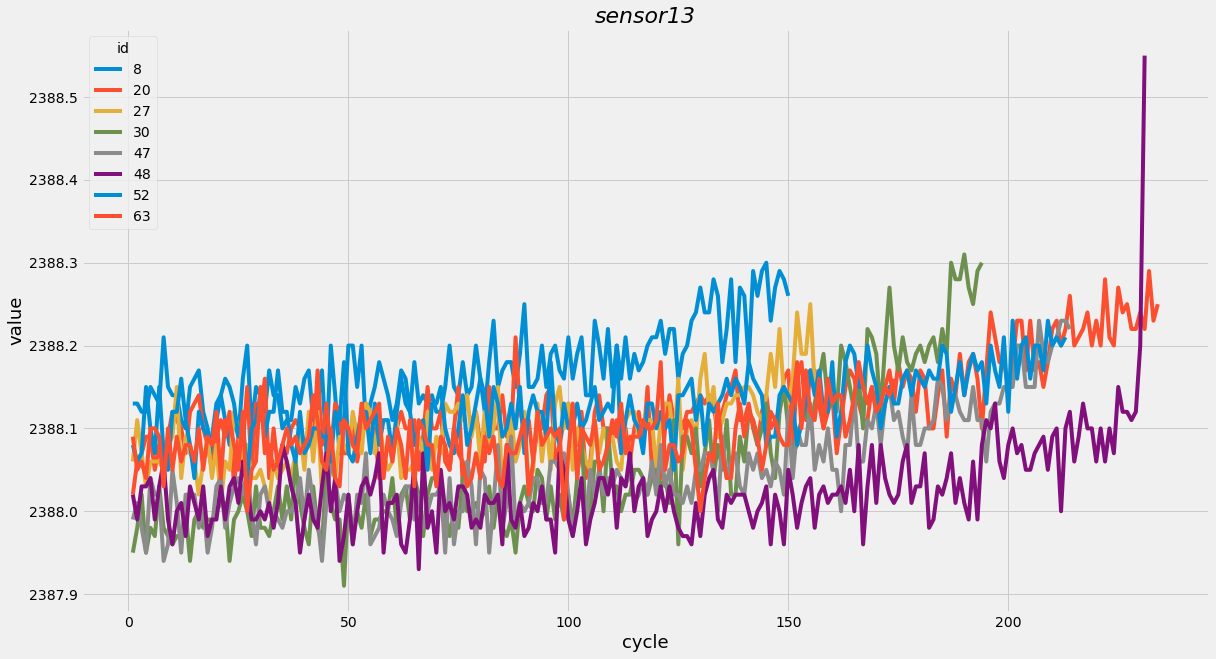

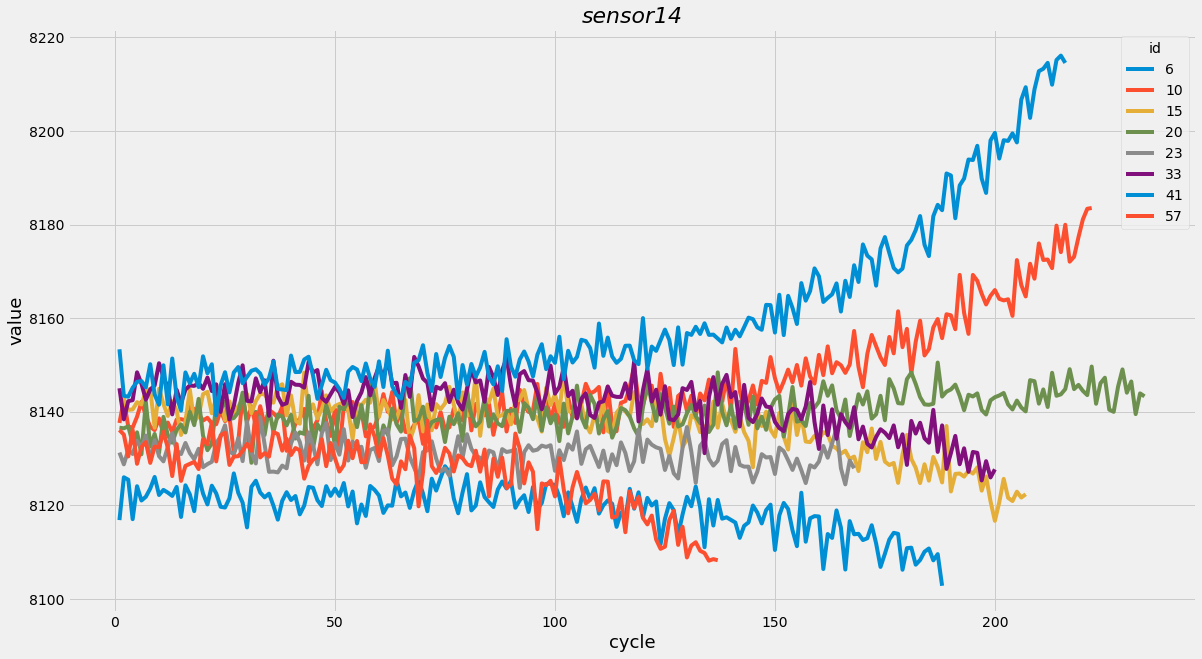

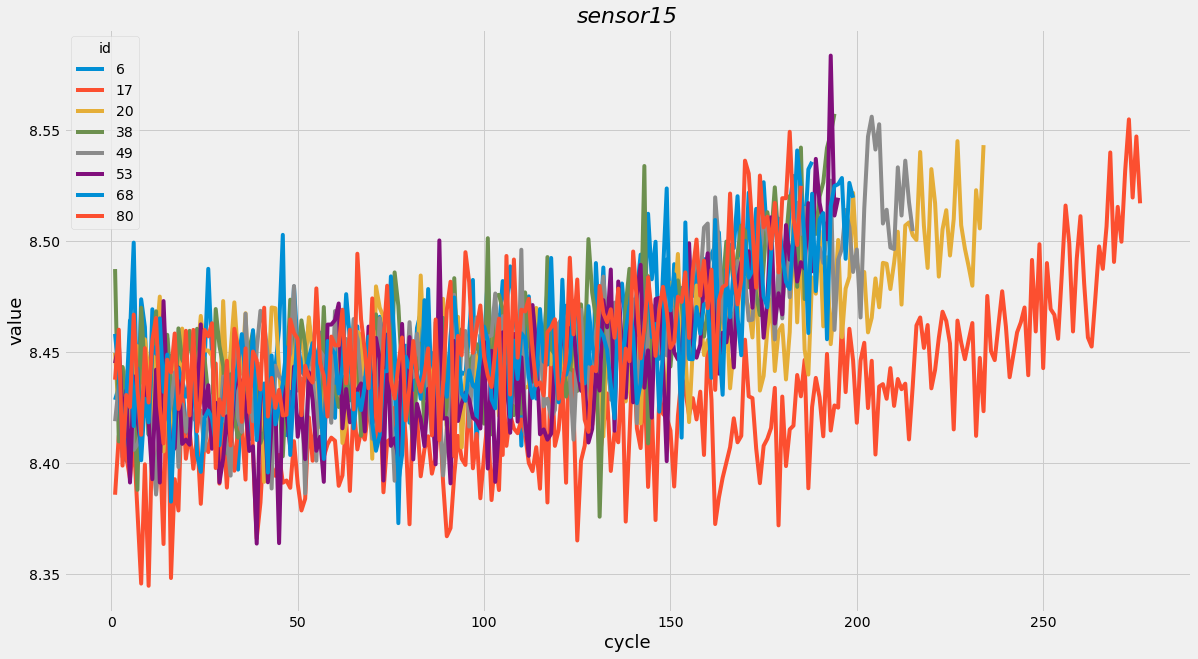

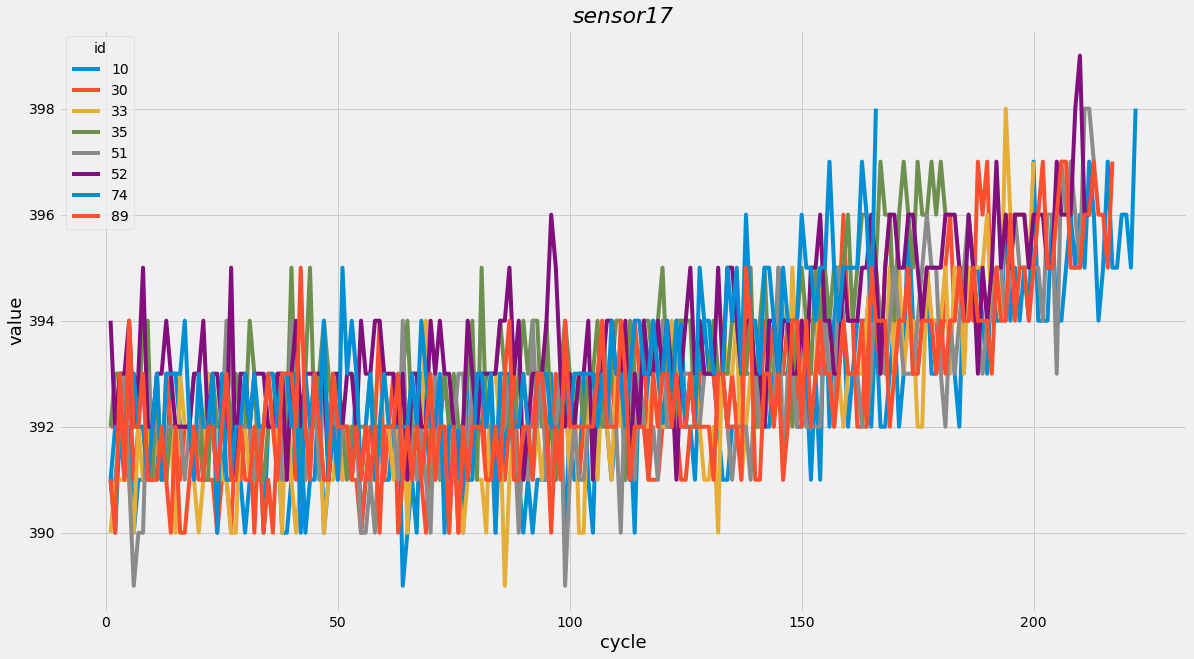

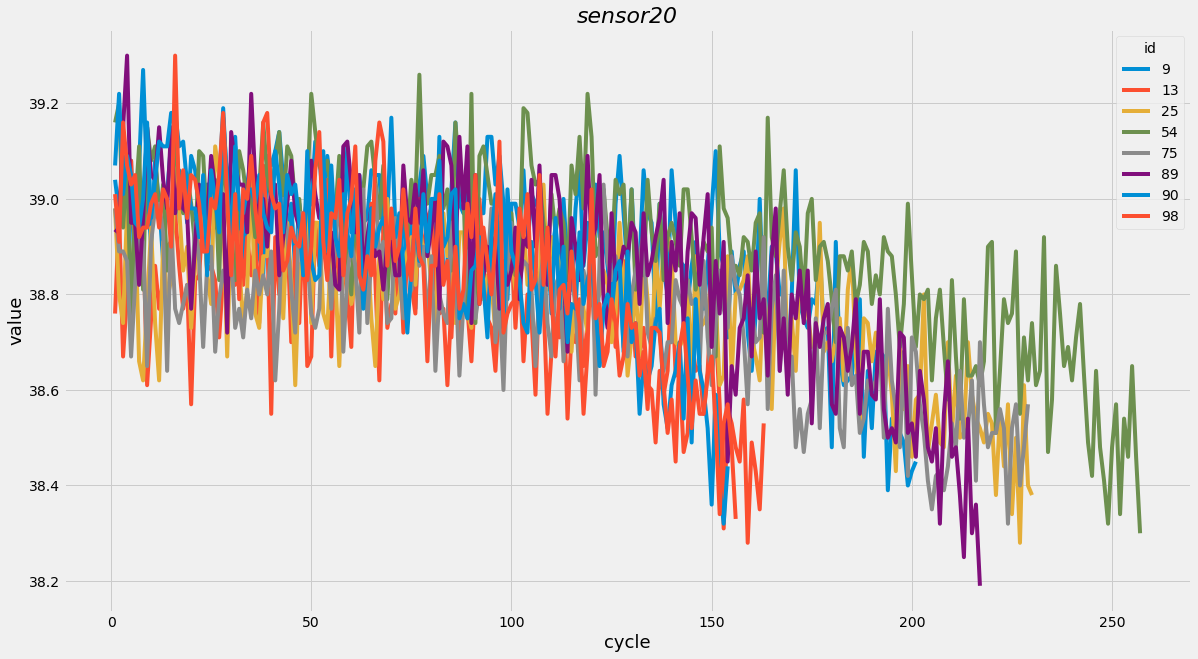

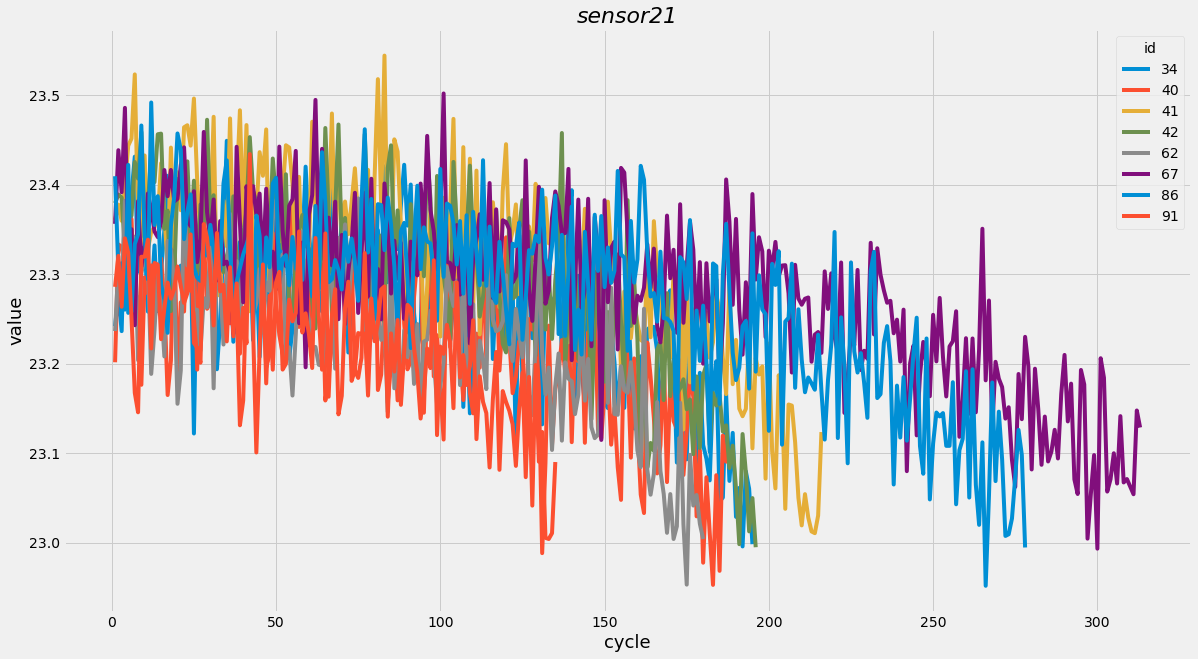

In [66]:
# Vẽ những dữ liệu của cảm biến thông qua RUL của một số động cơ
no_std_sensors = ['op3', 'sensor1', 'sensor5', 'sensor10',
                 'sensor16', 'sensor18', 'sensor19']
train = train_data.drop(no_std_sensors, axis=1)

def plot_ts_sensors(engine_ids, sensor):
    sub_df = train[train["id"].isin(engine_ids)][["id", "cycle", sensor]]
    sub_df = sub_df.pivot(columns="id", index="cycle", values=sensor)
    ax = sub_df.plot(figsize=(18,10))
    ax.set_title(f"{sensor}", fontsize=22, style="italic")
    ax.set_xlabel("cycle", fontsize=18)
    ax.set_ylabel("value", fontsize=18)
plt_sensors = list(train.columns)[2:]
num_ex = 8
for sens in plt_sensors:
    plot_ts_sensors(random.sample(range(1, 100), num_ex), sens)

## Xây dựng mô hình

In [67]:
# Lấy độ dài của dữ liệu của mỗi động cơ và chọn ngẫu nhiên 1 RUL dự đoán sớm
# Độ dài của dữ liệu của mỗi động cơ sẽ bằng số RUL của nó trong tập dữ liệu train.
def process_targets(data_length, early_rul = None):
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    
    num_batches = np.int32(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):

    max_num_test_batches = np.int32(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows


In [68]:
# Nhập tập dữ liệu test và RUL cho trước
test_data = pd.read_csv("C:/Users/phu20/OneDrive/Documents/lstm/CMaps/test_FD001.txt", sep = "\s+", header = None,names=columns )
true_rul = pd.read_csv("C:/Users/phu20/OneDrive/Documents/lstm/CMaps/RUL_FD001.txt", sep = '\s+', header = None)
# Thực hiện 1 cửa sổ kiểm tra cho mỗi động cơ 
# Output cuối cùng là đầu ra trung bình của tất cả các cửa sổ
window_length = 30
shift = 1
early_rul = 125 # RUL dự đoán sớm được lựa chọn là 125(tuỳ ý) và khi giá trị RUL kiểm tra đạt 125 nó sẽ bắt đầu giảm dần          
processed_train_data = []
processed_train_targets = []

num_test_windows = 5 
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped =['id','op1','op2','op3', 'sensor1', 'sensor5','sensor6','sensor7', 'sensor10',
                 'sensor16', 'sensor18', 'sensor19']

train_data_first_column = train_data ["id"]
test_data_first_column = test_data["id"]

# Cân bằng Tỉ lệ dữ liệu cho tất cả động cơ
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Xử lí dữ liệu train
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values
    
# Xác minh xem dữ liệu về độ dài cửa sổ đã cho có thể được trích xuất từ dữ liệu train hay không
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Xử lí dữ liệu test
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values
    
# Xác minh xem dữ liệu về độ dài cửa sổ đã cho có thể được trích xuất từ dữ liệu thử nghiệm hay không
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    
    # Chuẩn bị dữ liệu test
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Cài đặt hình dạng cho mô hình trước khi train
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed training data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)


Processed training data shape:  (17731, 30, 14)
Processed training ruls shape:  (17731,)
Processed test data shape:  (497, 30, 14)
True RUL shape:  (100,)


In [69]:
# lấy 20% từ tập dữ liệu train(lấy mẫu ngẫu nhiên) làm bộ xác thực
# Sau đó giám sát việc train mô hình sử dụng bộ xác thực này
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 83)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (14184, 30, 14)
Processed validation data shape:  (3547, 30, 14)
Processed train targets shape:  (14184,)
Processed validation targets shape:  (3547,)


## Đưa mô hình đã tạo vào LTSM để train
## LTSM
- Bộ nhớ dài-ngắn hạn hay Bộ nhớ ngắn-dài hạn (tiếng Anh: Long short-term memory, viết tắt LSTM) là một mạng thần kinh hồi quy (RNN) nhân tạo được sử dụng trong lĩnh vực học sâu.
- Mạng nơ-ron LSTM đã được chọn vì: nó phù hợp nhất cho dữ liệu lớn, dữ liệu chuỗi thời gian và bài toán tuần tự.

In [70]:
# Tạo mạng thần kinh hồi quy LTSM dùng để train mô hình đã tạo
def create_compiled_model():
    model = Sequential([
        layers.LSTM(128, input_shape = (window_length, 14), return_sequences=True, activation = "tanh"),
        layers.LSTM(64, activation = "tanh", return_sequences = True),
        layers.LSTM(32, activation = "tanh"),
        layers.Dense(96, activation = "relu"),
        layers.Dense(128, activation = "relu"),
        layers.Dense(1)
    ])
    model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

## Epoch
Để có thể đưa ra dự đoán trên LTSM ta dùng thuật toán tối ưu là Gradient Descent. Gradient Descent sử dụng Epoch, một Epoch được tính là khi chúng ta đưa tất cả dữ liệu trong tập train vào mạng neural network 1 lần.Thuật toán này đòi hỏi chúng ta phải đem toàn bộ dữ liệu qua mạng một vài lần để tìm được kết quả tối ưu. Vì vậy, khi dùng 1 epoch để huấn luyện mô hình thật sự không đủ để tìm được kết quả tốt nhất.

In [44]:
# Cấu hình số epoch cần dùng để đưa mô hình vào input của mạng(ở đây là 10)
def scheduler(epoch):
    if epoch < 5:
        return 0.001
    else:
        return 0.0001
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)
model = create_compiled_model()
history = model.fit(processed_train_data, processed_train_targets, epochs = 10,
                    validation_data = (processed_val_data, processed_val_targets),
                    callbacks = callback,
                    batch_size = 128, verbose = 2)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
111/111 - 18s - loss: 3340.7153 - val_loss: 410.2321 - lr: 0.0010 - 18s/epoch - 158ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
111/111 - 10s - loss: 262.5679 - val_loss: 199.1932 - lr: 0.0010 - 10s/epoch - 89ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
111/111 - 10s - loss: 181.1142 - val_loss: 151.3146 - lr: 0.0010 - 10s/epoch - 90ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
111/111 - 11s - loss: 151.6568 - val_loss: 141.4367 - lr: 0.0010 - 11s/epoch - 95ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/10
111/111 - 12s - loss: 137.3716 - val_loss: 117.0803 - lr: 0.0010 - 12s/epoch - 105ms/step

Epoch 6: LearningRateScheduler setting learning rate to 0.0001.
Epoch 6/10
111/111 - 12s - loss: 111.3915 - val_loss: 107.6125 - lr: 1.0000e-04 - 12s/epoch - 106ms/step

Epoch 

## Lỗi trung bình bình phương(RMSE)
- RMSE phục vụ để tổng hợp cường độ của các lỗi trong các dự đoán trong nhiều thời điểm khác nhau. RMSE là thước đo độ chính xác , để so sánh các lỗi dự báo của các mô hình khác nhau cho một tập dữ liệu cụ thể.
- Nó thực hiện điều này bằng cách đo sự khác biệt giữa các giá trị dự đoán và giá trị thực tế . RMSE càng nhỏ tức là sai số càng bé thì mức độ ước lượng cho thấy độ tin cậy của mô hình có thể đạt cao nhất.
- Công thức:
$$ RMSE=\sqrt{\sum_{i=1}^{n}\frac{{({\hat{y}}_i-y_i)}^2}{n}} $$ Trong đó :
 - $ {\hat{y}}_i $ là giá trị ước lượng.
 - $ y_{i\ } $ là biến độc lập.
 - n = (N – k – 1) với N : số tổng lượng biến quan sát, K : tổng lượng biến.

In [38]:
# Tính toán lỗi trung bình bình phương(RMSE)
rul_pred = model.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

16/16 [==============================] - 1s 13ms/step
RMSE:  14.872213227990379


In [46]:
# Lưu mô hình
tf.keras.models.save_model(model, "FD001_LSTM_piecewise_RMSE_"+ str(np.round(RMSE, 4)) + ".h5")
# Tính toán RMSE chỉ lấy kết quả cuối cùng của mỗi động cơ
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last results): ", RMSE_new)

RMSE (Taking only last results):  14.973895178827917


## S-score
- Đối với dữ liệu CMAPSS, cùng với RMSE, một số liệu khác (S-score) thường được báo cáo trong tài liệu.
- Điểm S-Score được định nghĩa là:
$$ S=\sum_{i=1}^{N}s_i $$ Trong đó :
$$ s_i=\left(e^\frac{{-d}_i}{13}\right)-1,\ \ \ for\ d_i<1 $$
$$ s_i=\left(e^\frac{d_i}{10}\right)-1,\ \ \ for\ d_i\geq1 $$

In [19]:
# Tính và in ra S-score
def compute_s_score(rul_true, rul_pred):
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

S-score:  488.3438401313012


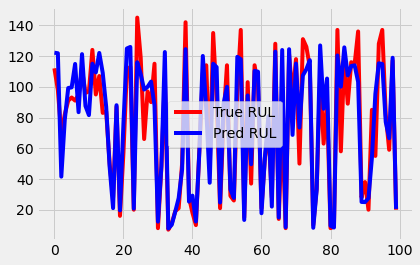

In [20]:
# Vẽ và so sánh giữa RUL trong tập dữ liệu cho trước và dữ liệu dự đoán
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

Kết quả dự đoán cho thấy so với RUL cho trước thì RUL dự đoán chênh lệch với sai số ít và chấp nhận được.